# Digit Recognition Using Deep Learning on MNIST Dataset

In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import time
import tensorflow as tf
import math

In [2]:
def convert_to_one_hot(Y, n = 10):
    one_hot = []
    for i in range(len(Y)):
        current = np.zeros((n,1))
        current[Y[i]] = 1
        one_hot.append(current)
    return one_hot
def load_data(filePath):
    Y = []
    X = []
    with open(filePath) as csv_file:
        readData = csv.reader(csv_file, delimiter = ',')
        next(readData)
        for row in readData:
            if filePath == "train.csv":
                Y.append(int(row[0]))
                del row[0]
                X.append(list(map(int,row)))
            elif filePath == "test.csv":
                X.append(list(map(int,row)))
    Y_hot = []
    if filePath == "train.csv":
        Y = np.array(Y)
        Y = Y.T
        Y_hot = convert_to_one_hot(Y,10)
        Y_hot = np.array(Y_hot)
        Y_hot = Y_hot.T
        Y_hot = Y_hot.reshape((Y_hot.shape[1],Y_hot.shape[2]))
    X = np.array(X)
    X = X.T
    if filePath == "train.csv":
        return X,Y,Y_hot
    return X
#this cell contains no mistakes

In [3]:
X_train,Y_train,Y_train_hot = load_data("train.csv")
X_test = load_data("test.csv")

In [4]:
def partition(X,Y,batch_size=420):
    m = X.shape[1]
    batches = []
    nb_batches = int(m/batch_size)
    
    for i in range(0,nb_batches):
        current_X = X[:,(i)*batch_size:(i+1)*batch_size-1]
        current_Y = Y[:,(i)*batch_size:(i+1)*batch_size-1]
        batch = (current_X,current_Y)
        batches.append(batch)
    return batches
def random_mini_batches(X, Y, mini_batch_size = 420):    
    m = X.shape[1]                  
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [52]:
print(Y_train_hot.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(10, 42000)
(784, 42000)
(784, 28000)
(42000,)


The label is: 2


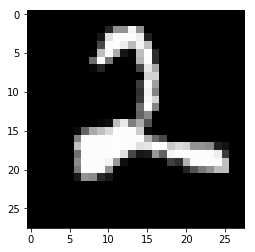

In [53]:
digit = X_test[:,55].reshape((28,28),order='C')
plt.imshow(digit, cmap='gray', interpolation='nearest');
print("The label is: " + str(Y_train[55]))

In [5]:
def initialize_parameters_tf(layers_dims=[784,15,15,10]):
    L = len(layers_dims)
    tf.set_random_seed(1)
    tf.reset_default_graph()
    parameters = {}
    for l in range(1,L):
        parameters["W"+str(l)] = tf.get_variable("W"+str(l), [layers_dims[l], layers_dims[l-1]],
                                                 initializer=tf.contrib.layers.xavier_initializer(seed=1))
        parameters["b"+str(l)] = tf.get_variable("b"+str(l),shape= [layers_dims[l],1],
                            initializer=tf.zeros_initializer())
    return parameters

In [6]:
def create_placeholders(n1,n2):
    X = tf.placeholder(tf.float32,(n1,n2))
    return X
def linear_forward_tf(A_prev,W,b):
    Z = tf.add(tf.matmul(W, A_prev), b)
    return Z
def linear_forward_activation_tf(A_prev,W,b):
    Z = linear_forward_tf(A_prev,W,b)
    A = tf.nn.relu(Z)
    return A
def L_model_forward_tf(X,parameters,layer_dims):
    X = tf.cast(X,dtype=tf.float32)
    L = len(layer_dims)
    A_prev = X
    Z_final = 0
    for l in range(1,L):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        if l == L-1:
            Z_final = linear_forward_tf(A_prev,W,b)
        elif l < L-1:
            A_prev = linear_forward_activation_tf(A_prev,W,b)
    return Z_final   

In [7]:
def compute_cost(Z_final, Y):
    logits = tf.transpose(Z_final)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))    
    return cost

In [8]:
def NN_model_tf(X_train,Y_train_hot,learning_rate = 0.0001,nb_epochs = 2000,
                layers_dims=[784,15,15,10],mini_batch_size = 420):
    parameters = initialize_parameters_tf(layers_dims)
    costs = []
    n_x = 784
    m = 42000
    n_y = 10
    X = create_placeholders(n_x,420)
    Y = create_placeholders(n_y,420)
    Z_final = L_model_forward_tf(X,parameters,layers_dims)
    cost = compute_cost(Z_final,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(cost)
    init = tf.global_variables_initializer()
    seed = 0 
    with tf.Session() as sess:
        sess.run(init)
        nb_mini_batch = int(m/mini_batch_size)
        for i in range(nb_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / mini_batch_size)
            seed = seed + 1
            batches = random_mini_batches(X_train, Y_train_hot, mini_batch_size, seed)

            for minibatch in batches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([train, cost], 
                                             feed_dict={X: minibatch_X, 
                                                        Y: minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches
            if i%100 == 0:
                print("Cost value at iteration "+str(i)+"th = "+str(epoch_cost))
            costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')       
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters_values = sess.run(parameters)
    return parameters_values

In [ ]:
parameters = NN_model_tf(X_train,Y_train_hot)

In [ ]:
X = create_placeholders(784,28000)
Z_test = L_model_forward_tf(X,parameters,layer_dims)
Y_pred = tf.nn.softmax(Z_test,axis=1)
with tf.Session() as sess:
    Z_test_value = sess.run(Z_test,feed_dict={X:X_test})
    Y_test = sess.run(Y_pred,feed_dict={Z_test:Z_test_value})
    Y_test = np.array(Y_test)
Y_real = np.zeros_like(Y_test)
Y_real[np.arange(len(Y_test)), Y_test.argmax(1)] = 1

index = 55
maxIndex = np.max(Y_real[:,index])
digit = X_test[:,index].reshape((28,28),order='C')
plt.imshow(digit, cmap='gray', interpolation='nearest');
print("The label is: " + str(Y_real[:,index]))